## Setup

!pip install -U googlemaps

In [45]:
import pandas as pd
import pickle
import googlemaps
from collections import defaultdict

In [46]:
df = pd.read_csv('./inmates.csv')

In [47]:
df.head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,nameLast,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix
0,0,01/14/1985,71.0,SDC,San Diego,MCC,/locations/institutions/sdc/,77709-098,NaN,MARCOS,ALVAREZ,OLIVO,NaN,White,98,R,Male,NaN
1,1,04/25/2018,57.0,SEA,Seagoville,FCI,/locations/institutions/sea/,31526-001,NaN,PATRICK,MINGA,R,NaN,White,1,R,Male,NaN
2,2,12/09/2013,28.0,NYM,New York,MCC,/locations/institutions/nym/,64418-054,NaN,DEMETRIUS,SCOTT,NaN,NaN,Black,54,R,Male,NaN
3,3,08/10/2007,44.0,BSC,Big Spring,CI,/locations/ci/bsc/,27208-180,NaN,ADRIAN,VALDEZ-VISCAINO,RENE,NaN,White,180,R,Male,NaN
4,4,NaN,38.0,NaN,IN TRANSIT,NaN,NaN,82108-279,NaN,JOSE,FAZ-TORRES,ANDRES,UNKNOWN,White,279,NaN,Male,NaN


In [48]:
# want inmateNum into region num and id num
df['inmateId'] = df['inmateNum'].apply(lambda s: int(s.split('-')[0]))

## Background and Schema

### `faclType`

| Security | Code | Type |
| --- | --- | --- |
| Minimum | FPC | Federal Prison Camp |
| Minimum | SPC | Satellite Prison Camp |
| Low | FCI | Federal Correctional Institutions |
| Low | FSL | Federal Satellite Low Security |
| Medium | FCI | Federal Correctional Institutions |
| High | USP | United States Penitentiaries |
| Complex | FCC | Federal Correctional Complexes |
| Administrative | MCC | Metropolitan Correctional Centers |
| Administrative | MDC | Metropolitan Detention Centers |
| Administrative | FDC | Federal Detention Centers |
| Administrative | FMC | Federal Medical Center |
| Administrative | FTC | Federal Transfer Center |
| Administrative | MCFP | Medical Center for Federal Prisioners |
| Administrative | ADX | Administrative-Maximum Security Penitentiary |
| Administrative | RO | Regional Office |
| Administrative | RRM | Residential Reentry Management Centers |


In [49]:
df['faclType'].unique()

array(['MCC', 'FCI', 'CI', nan, 'RRM', 'FMC', 'USP', 'FDC', 'MDC', 'RO',
       'FPC', 'MCFP', 'FTC'], dtype=object)

### Register Number Codes
> The United States Marshals Service and the Federal Bureau of Prisons assigns a eight digit "Register Number" to all offenders in the following format:  XXXXX-0XX.   The last three digits signify the district wherein the offender was arrested and or processed into the system.  In large districts, where over 100,000 people have been processed, the '"0" is replaced with a "1". [[source](http://www.fedcure.org/information/RegisterNumberCodes.shtml#.XvawAmpKhb8)]

We thus expect the region numbers to be distributed with a far right tail.

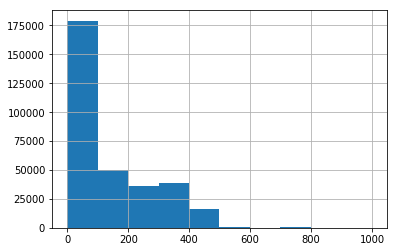

In [50]:
df['region'].hist()

To actually determine the regional distribution, we should remove the first digit from the region.

In [51]:
df['_region'] = df['region']
df['regionNum'] = df['_region'].apply(lambda s: int(int(s) % 100))
df.head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,...,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix,inmateId,_region,regionNum
0,0,01/14/1985,71.0,SDC,San Diego,MCC,/locations/institutions/sdc/,77709-098,NaN,MARCOS,...,OLIVO,NaN,White,98,R,Male,NaN,77709,98,98
1,1,04/25/2018,57.0,SEA,Seagoville,FCI,/locations/institutions/sea/,31526-001,NaN,PATRICK,...,R,NaN,White,1,R,Male,NaN,31526,1,1
2,2,12/09/2013,28.0,NYM,New York,MCC,/locations/institutions/nym/,64418-054,NaN,DEMETRIUS,...,NaN,NaN,Black,54,R,Male,NaN,64418,54,54
3,3,08/10/2007,44.0,BSC,Big Spring,CI,/locations/ci/bsc/,27208-180,NaN,ADRIAN,...,RENE,NaN,White,180,R,Male,NaN,27208,180,80
4,4,NaN,38.0,NaN,IN TRANSIT,NaN,NaN,82108-279,NaN,JOSE,...,ANDRES,UNKNOWN,White,279,NaN,Male,NaN,82108,279,79


In [52]:
df.groupby('regionNum').count().head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,nameLast,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix,inmateId,_region
regionNum,,,,,,,,,,,,,,,,,,,,
0,873,759,872,765,873,765,765,873,0,873,873,308,114,873,873,759,873,16,873,873
1,1238,1097,1234,1152,1238,1152,1152,1238,0,1238,1238,929,141,1238,1238,1097,1238,69,1238,1238
2,212,176,212,202,212,202,202,212,0,212,212,146,36,212,212,176,212,11,212,212
3,889,752,889,825,889,825,825,889,0,889,889,674,137,889,889,752,889,61,889,889
4,10241,9196,10235,8905,10241,8905,8905,10241,0,10241,10241,4646,1045,10241,10241,9196,10241,153,10241,10241


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e604f6a20>]],
      dtype=object)

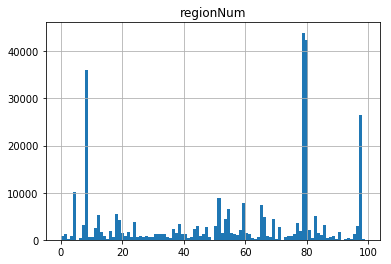

In [53]:
df.hist('regionNum', bins=101)

In [54]:
df['gmap_query'] = df['faclName'] + ' ' + df['faclType']

In [55]:
queries = list(set(df['gmap_query']))

loading the hand compiled locations of prisons

In [56]:
with open('./prisonResponses.p', 'rb') as fp:
    responses = pickle.load(fp)

In [57]:
responses[3]

('Tucson USP',
 [{'address_components': [{'long_name': '9300',
     'short_name': '9300',
     'types': ['street_number']},
    {'long_name': 'South Wilmot Road',
     'short_name': 'S Wilmot Rd',
     'types': ['route']},
    {'long_name': 'Tucson',
     'short_name': 'Tucson',
     'types': ['locality', 'political']},
    {'long_name': 'Pima County',
     'short_name': 'Pima County',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Arizona',
     'short_name': 'AZ',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'United States',
     'short_name': 'US',
     'types': ['country', 'political']},
    {'long_name': '85756', 'short_name': '85756', 'types': ['postal_code']}],
   'formatted_address': '9300 S Wilmot Rd, Tucson, AZ 85756, USA',
   'geometry': {'location': {'lat': 32.0847301, 'lng': -110.865276},
    'location_type': 'ROOFTOP',
    'viewport': {'northeast': {'lat': 32.0860790802915,
      'lng': -110.8639270197085}

In [69]:
def getRow(entry):
    name = entry[0]
    response = entry[1]
    try:
        address = response[0]['formatted_address']
        pair = response[0]['geometry']['location']
        return (name, pair['lat'], pair['lng'], address)
    except:
        print(name)

In [71]:
coords = pd.DataFrame([getRow(e) for e in filter(lambda r: r[0] != 'nan', responses)])
coords.columns = ['gmap_query', 'lat', 'lng', 'address']

Southeast RO


In [88]:
# correction 32.7321° N, 96.9907° W, 344 Armed Forces Dr #300, Grand Prairie, TX 75051
coords.loc[coords['gmap_query'] == 'North Central RO', 'lat'] = 32.7321
coords.loc[coords['gmap_query'] == 'North Central RO', 'lng'] = 96.9907
coords.loc[coords['gmap_query'] == 'North Central RO', 'address'] = "344 Armed Forces Dr #300, Grand Prairie, TX 75051"


In [110]:
def getStateFromAddress(address):
    
    state = ''
    if address is not None:
        vals = address.split(',')
        
        if len(vals) == 3:
            # just city, state, country
            state = vals[1]
        else:
            state = vals[-2].strip().split(' ')[0]
            
    state = state.strip()
    
    if len(state) == 2:
        return state
    
    else:
        return state.split(' ')[0]
    
coords['state'] = coords['address'].apply(getStateFromAddress)

In [111]:
pdf = df.merge(coords, on = 'gmap_query')

## Analysis

In [112]:
md_lat = coords['lat'].median()
md_lng = coords['lng'].median()

def getNorthSouth(lat):
    if lat > md_lat:
        return 'North'
    return 'South'

def getEastWest(lng):
    if lng < md_lng:
        return 'West'
    return 'East'

In [113]:
pdf['orientation_y'] = pdf['lat'].apply(getNorthSouth)

In [114]:
pdf['orientation_x'] = pdf['lng'].apply(getEastWest)

In [115]:
pdf.head().columns

Index(['Unnamed: 0', 'actRelDate', 'age', 'faclCode', 'faclName', 'faclType',
       'faclURL', 'inmateNum', 'inmateNumType', 'nameFirst', 'nameLast',
       'nameMiddle', 'projRelDate', 'race', 'region', 'releaseCode', 'sex',
       'suffix', 'inmateId', '_region', 'regionNum', 'gmap_query', 'lat',
       'lng', 'address', 'state', 'orientation_y', 'orientation_x'],
      dtype='object')

In [116]:
pdf.head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,...,inmateId,_region,regionNum,gmap_query,lat,lng,address,state,orientation_y,orientation_x
0,0,01/14/1985,71.0,SDC,San Diego,MCC,/locations/institutions/sdc/,77709-098,NaN,MARCOS,...,77709,98,98,San Diego MCC,32.713887,-117.166165,"808 Union St, San Diego, CA 92101, USA",CA,South,West
1,12,03/19/2009,34.0,SDC,San Diego,MCC,/locations/institutions/sdc/,13614-298,NaN,JESSICA,...,13614,298,98,San Diego MCC,32.713887,-117.166165,"808 Union St, San Diego, CA 92101, USA",CA,South,West
2,26,08/18/2010,35.0,SDC,San Diego,MCC,/locations/institutions/sdc/,21704-298,NaN,EUGENIO,...,21704,298,98,San Diego MCC,32.713887,-117.166165,"808 Union St, San Diego, CA 92101, USA",CA,South,West
3,43,05/19/1998,67.0,SDC,San Diego,MCC,/locations/institutions/sdc/,51196-198,NaN,JAVIER,...,51196,198,98,San Diego MCC,32.713887,-117.166165,"808 Union St, San Diego, CA 92101, USA",CA,South,West
4,83,09/28/1983,66.0,SDC,San Diego,MCC,/locations/institutions/sdc/,67416-098,NaN,ALEJO,...,67416,98,98,San Diego MCC,32.713887,-117.166165,"808 Union St, San Diego, CA 92101, USA",CA,South,West


In [118]:
pdf.to_csv('./inmatesWithCoords.csv')